In [1]:
import numpy as np
import math

In [2]:
class Generator:
    def __init__(self,          
                 Xdims, #number of independent variables
                 ydims, #number of dependent variables
                 drift=0.05, #average distance of movement
                 sharpness=1, #sporadicity of movement
                 noise=0, #magnitude of randomness of y
                 width=3 #interval on which theta is randomly initialised about 0
                ): 
        
        self.Xdims = Xdims
        self.ydims = ydims
        self.drift = drift
        self.sharpness = sharpness
        self.noise = noise
        
        self.theta = width*(2*np.matrix(np.random.rand(Xdims+1, ydims)-1)/math.sqrt(Xdims * ydims))
        
    def generate(self, observations=1):
        X = np.matrix(np.random.rand(observations, self.Xdims))
        
        X_ = np.matrix(np.ones((observations, self.Xdims+1)))
        X_[:,:-1] = X
        
        y = X_ * self.theta
        y = y
        return X, y
    
    def deviate(self):
        unit_move = np.random.randn(self.Xdims+1, self.ydims)
        unit_move = unit_move/ np.linalg.norm(unit_move)
        
        move = unit_move * self.drift * (self.sharpness + 1) * np.random.rand(1) ** self.sharpness
        self.theta = self.theta + move

In [3]:
G = Generator(4, 2)
G.generate()

(matrix([[ 0.86736378,  0.9249692 ,  0.17674629,  0.28203144]]),
 matrix([[-3.44229132, -4.56234863]]))

In [4]:
class OnlineMLRegressor:
    def __init__(self, Xdims, ydims, learning_rate=0.1):
        self.Xdims = Xdims
        self.ydims = ydims
        self.learning_rate = learning_rate
        
        self.theta = np.matrix(np.random.rand(Xdims+1, ydims)/math.sqrt(Xdims * ydims))
        
    def learn(self, X, y):
        X_ = np.matrix(np.ones((np.shape(X)[0], self.Xdims+1)))
        X_[:,:-1] = X
        
        delta_y = (y - X_ * self.theta)
        grad_theta = X_.transpose() * delta_y
        self.theta = self.theta + self.learning_rate * grad_theta / np.shape(X)[0]  

In [5]:
def MSE(x, y):
    return np.linalg.norm(x - y)**2/np.prod(np.size(x))

In [6]:
def test1(lr, iterations, dr=0.05, sharp=1, verbose=False, sigma=0.1):
    G = Generator(3, 1, drift=dr, sharpness=sharp, noise=sigma)
    O = OnlineMLRegressor(3, 1, learning_rate=lr)
    vals = []
    for i in range(iterations):
        X, y = G.generate()
        O.learn(X,y)
        vals.append(MSE(G.theta, O.theta))
        if (i+1) % 100 == 0 and verbose:
            print("error after",i+1,"timesteps:", MSE(G.theta, O.theta))       
        G.deviate()
        
    return vals

vals = test1(0.1, 1000, verbose=True)

error after 100 timesteps: 0.616917430357
error after 200 timesteps: 0.328456716726
error after 300 timesteps: 0.0898530461288
error after 400 timesteps: 0.0364594926066
error after 500 timesteps: 0.0166332743436
error after 600 timesteps: 0.00643778387061
error after 700 timesteps: 0.0655715317313
error after 800 timesteps: 0.0670540427359
error after 900 timesteps: 0.0610018711972
error after 1000 timesteps: 0.0218399840548


In [7]:
import matplotlib.pyplot as plt
import pandas as pd

learning_rates = (0.01, 0.03, 0.1, 0.3, 0.5, 1)
sharpness = 5
drift = 0.05
iters = 5000

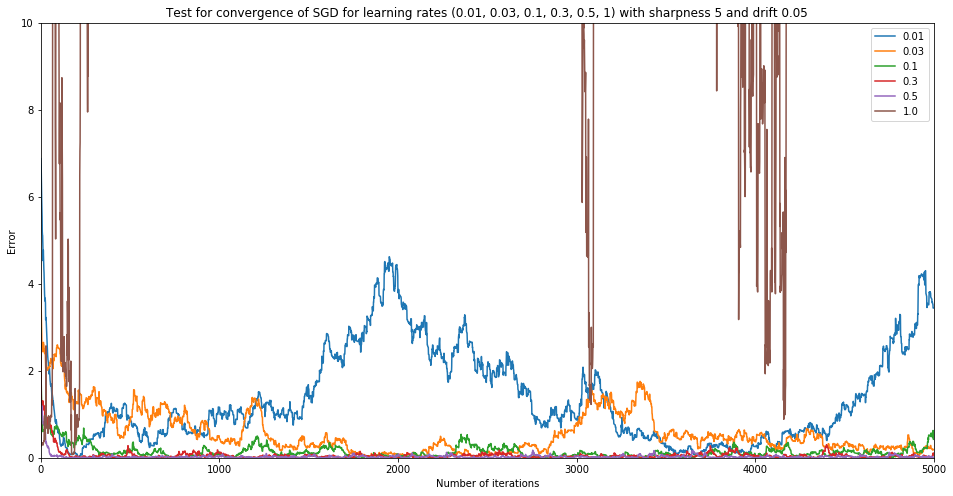

In [8]:
frames = []

for i in learning_rates:
    vals = pd.DataFrame(test1(i, dr=drift, sharp=sharpness, iterations=iters, sigma=0.5))
    vals.columns = [i]                        
    frames.append(vals)
      
df = pd.concat(frames, axis=1)
df.plot(figsize=(16,8))

plt.xlim([0,iters])
plt.ylim([0,10])
plt.title("Test for convergence of SGD for learning rates " + repr(learning_rates) + " with sharpness " + str(sharpness) + " and drift " + str(drift))
plt.xlabel("Number of iterations")
plt.ylabel("Error")
plt.show()

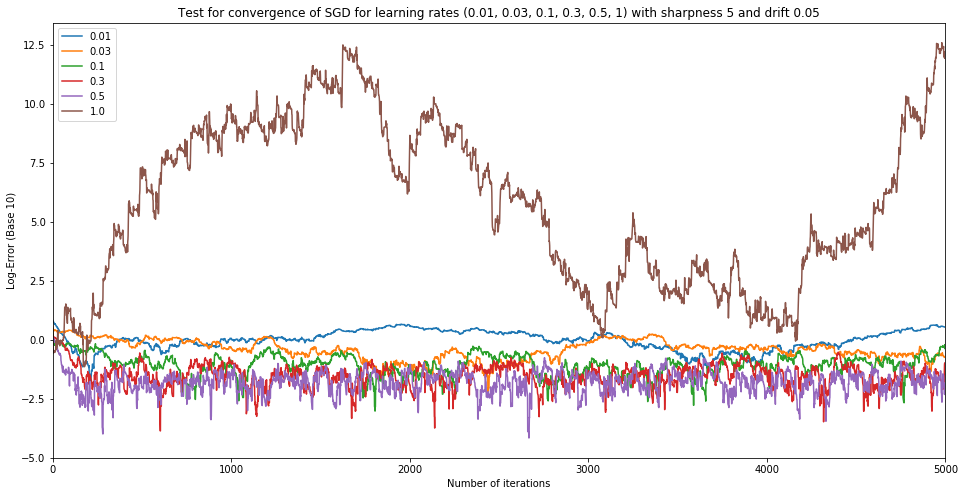

In [9]:
(np.log(df)/math.log(10)).plot(figsize=(16,8))
plt.title("Test for convergence of SGD for learning rates " + repr(learning_rates) + " with sharpness " + str(sharpness) + " and drift " + str(drift))
plt.xlabel("Number of iterations")
plt.ylabel("Log-Error (Base 10)")
plt.xlim([0,iters])
plt.show()

In [10]:
def test2(lr, iterations, recall=5, dr=0.05, sharp=1, verbose=False, sigma=0.1):
    G = Generator(3, 1, drift=dr, sharpness=sharp, noise=sigma)
    O = OnlineMLRegressor(3, 1, learning_rate=lr)
    vals = []
    
    cum_X = np.matrix([])
    cum_y = np.matrix([])
    for i in range(iterations):
        X, y = G.generate()
        
        if i != 0:
            cum_X = np.concatenate((cum_X, X), axis=0)[-recall:,:]
            cum_y = np.concatenate((cum_y, y), axis=0)[-recall:,:]
        else:
            cum_X = X
            cum_y = y
            
        O.learn(cum_X,cum_y)
        vals.append(MSE(G.theta, O.theta))
        if (i+1) % 100 == 0 and verbose:
            print("error after",i+1,"timesteps:", MSE(G.theta, O.theta))       
        G.deviate()
        
    return vals

vals = test2(0.1, 1000, verbose=True)

error after 100 timesteps: 0.0873192336513
error after 200 timesteps: 0.0914655378872
error after 300 timesteps: 0.0603902175301
error after 400 timesteps: 0.100443394556
error after 500 timesteps: 0.0187943659689
error after 600 timesteps: 0.0597967226744
error after 700 timesteps: 0.122621311779
error after 800 timesteps: 0.0174323186788
error after 900 timesteps: 0.0184010891129
error after 1000 timesteps: 0.0869622073216


In [11]:
def recall_test(rc):
    frames = []
    for i in learning_rates:
        vals = pd.DataFrame(test2(i, dr=drift, sharp=sharpness, recall=rc, iterations=iters, sigma=0.5))
        vals.columns = [i]                        
        frames.append(vals)

    df = pd.concat(frames, axis=1)
    df.plot(figsize=(14,7))

    plt.xlim([0,iters])
    plt.ylim([0,5])
    plt.title("Test for convergence of BGD with recall for learning rates " + repr(learning_rates) +
              " with sharpness " + str(sharpness) + ", drift " + str(drift) + " and recall " + str(rc))
    plt.xlabel("Number of iterations")
    plt.ylabel("Error")
    plt.show()

    (np.log(df)/math.log(10)).plot(figsize=(14,7))
    plt.title("Test for convergence of BGD with recall for learning rates " + repr(learning_rates) +
              " with sharpness " + str(sharpness) + ", drift " + str(drift) + " and recall " + str(rc))
    plt.xlabel("Number of iterations")
    plt.ylabel("Log-Error (Base 10)")
    plt.xlim([0,iters])
    plt.show()

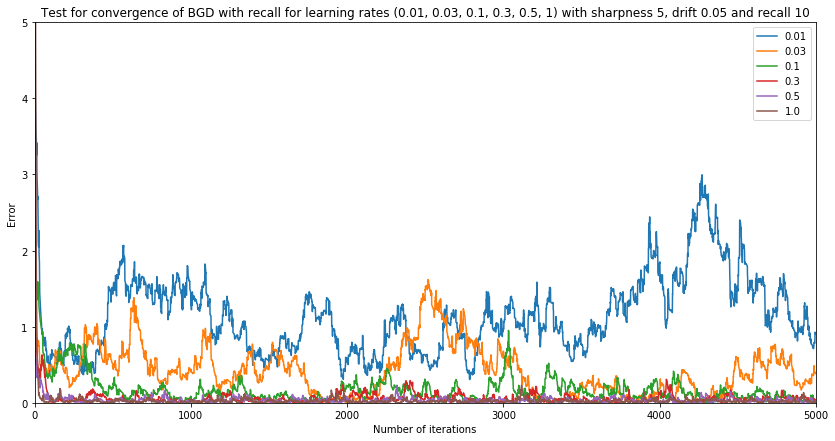

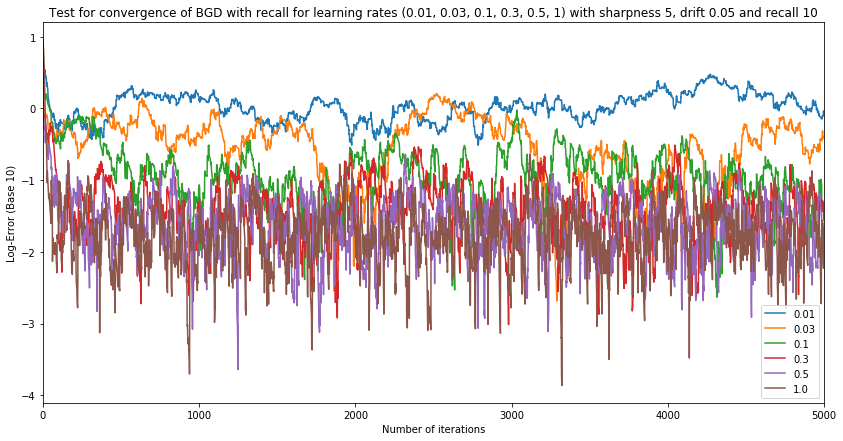

In [12]:
recall_test(10)

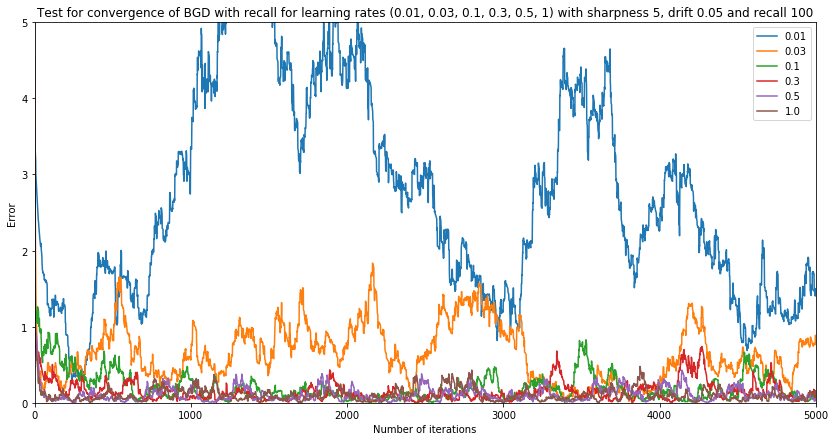

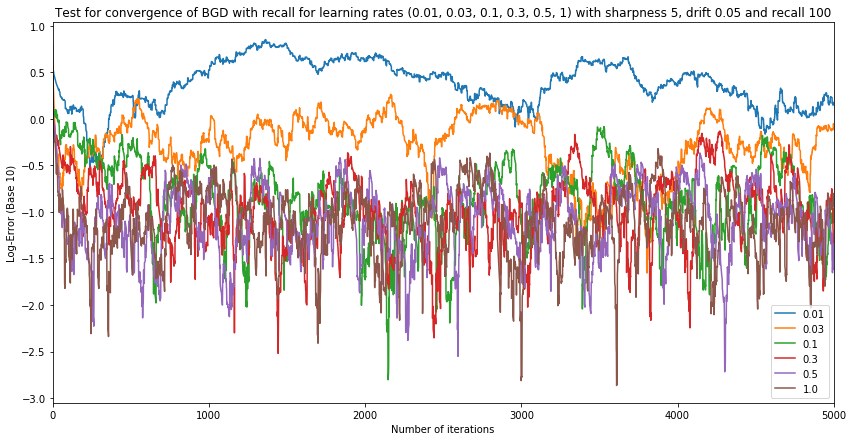

In [13]:
recall_test(100)

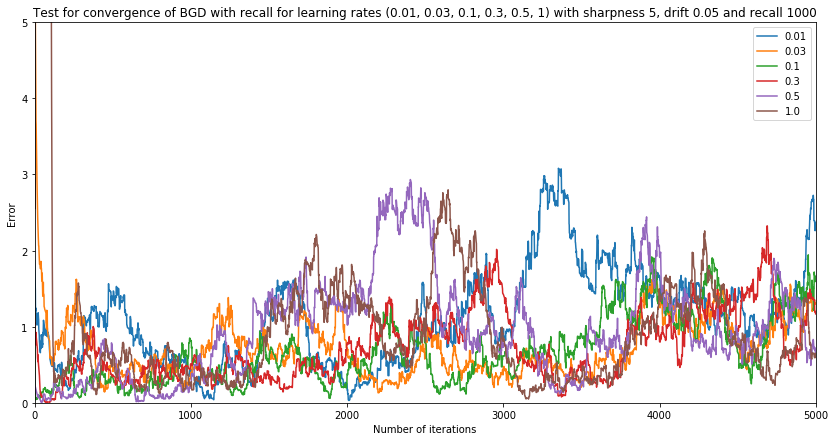

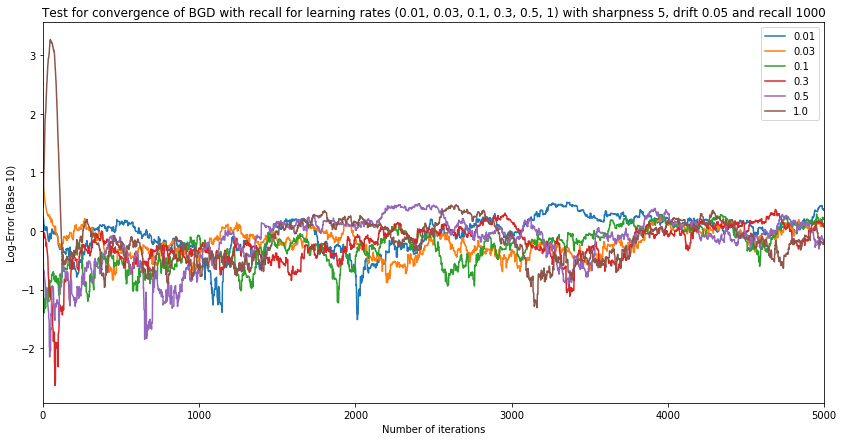

In [14]:
recall_test(1000)